# HSQL calculation

This notebook calculates HQSL for Santiago's project.

By changing parameters_dict:
* __'santiago_hexproximity_hqsl_4_5_kmh'__ includes _priv source names from educational categories.
* __'santiago_hexproximity_hqsl_4_5_kmh_pub'__ does __NOT__ include _priv source names from educational categories.

_priv source names from educational categories: 'jardin_inf_priv','edu_especial_priv','edu_basica_priv','edu_media_priv','edu_adultos_priv'

## Import libraries

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import seaborn as sns
import numpy as np

import os
import sys
module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/edgaregurrola/Repos/observatorio-ciudades/accesibilidad-urbana/aup/data.py:24: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(


## Notebook config

In [2]:
##### WARNING ##### WARNING ##### WARNING ##### WARNING ##### WARNING #####

# save output to database?
save = True
# How to save?
if_exists='replace'

##### WARNING ##### WARNING ##### WARNING ##### WARNING ##### WARNING #####

In [3]:
# 'alex' or 'edgar'
all_local_dirs = 'edgar'
# Output hexs resolution
res = 10

In [4]:
if all_local_dirs == 'alex':
    grl_dir = "../../../data/external/temporal_todocker/santiago/proximidad/"
elif all_local_dirs == 'edgar':
    grl_dir = "../../../data/processed/santiago/"
else:
    print("WARNING: Fix all_local_dirs variable")

## Download data

In [5]:
query = f'SELECT * FROM projects_research.santiago_hexproximity_hqsl_4_5_kmh_pub WHERE res = {res}'
hex_gdf = aup.gdf_from_query(query)

# Show
print(hex_gdf.shape)
hex_gdf.head(1)

(63727, 201)


,hex_id,geometry,supermercado_time,supermercado_count_15min,clinica_priv_time,clinica_priv_count_15min,clinica_pub_time,clinica_pub_count_15min,hospital_priv_time,hospital_priv_count_15min,...,culture_count,greenspace_count,entertainment_count,enjoying_count,education_count,learning_count,workplaces_count,sustainable_mobility_count,working_count,hqsl
0,8ab2c556d697fff,"POLYGON ((-70.59586 -33.41622, -70.59649 -33.4...",3.707278,4.251,0.621772,5.167667,38.784833,0.001,65.502859,0.001,...,14.16163,7.882002,17.525184,4.946102,32.996476,4.124559,8.641466,27.953463,7.318986,34.025012


## Load data

In [6]:
uv_gdf = gpd.read_file(f"../../../data/processed/santiago/Unidades_Vecinales.shp")
print(uv_gdf.shape)
uv_gdf.head(4)

(3675, 78)


,NOMBRE_REG,CODIGO_REG,NOMBRE_COM,CUT,NOMBRE_UV,CODIGO_UV,PORC_VIV,COD_UNICO_,PERSONAS,HOMBRE,...,SALUD_ALTA,SALUD_MEDI,SALUD_BAJA,SALUD_SIN_,SALUD_PRIV,SALUD_PUBL,SALUD_OTRO,TOTAL_SALU,per_num,geometry
0,AYSÉN DEL GENERAL CARLOS IBÁÑEZ DEL CAMPO,11,COYHAIQUE,11101,CERRO LA VIRGEN,15,16.3265,11101_15,72,45,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,72.0,"POLYGON ((-71.92013 -45.80636, -71.92012 -45.8..."
1,AYSÉN DEL GENERAL CARLOS IBÁÑEZ DEL CAMPO,11,COYHAIQUE,11101,BALMACEDA,13,68.7332,11101_13,483,292,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,483.0,"POLYGON ((-71.75999 -45.78404, -71.75999 -45.7..."
2,AYSÉN DEL GENERAL CARLOS IBÁÑEZ DEL CAMPO,11,COYHAIQUE,11101,VILLA FREI,34,36.7003,11101_34,163,87,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,163.0,"POLYGON ((-72.02131 -45.81552, -72.02347 -45.8..."
3,AYSÉN DEL GENERAL CARLOS IBÁÑEZ DEL CAMPO,11,COYHAIQUE,11101,VALLE SIMPSON,16,77.6744,11101_16,336,165,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,336.0,"POLYGON ((-72.07738 -45.71915, -72.08222 -45.7..."


## Hexagon to UV

Source data

In [7]:
source_list = ['supermercado','clinica_priv','clinica_pub',
                   'hospital_priv','hospital_pub',
                   'consult_ado_priv','consult_ado_pub',
                   'club_deportivo','eq_deportivo_pub','eq_deportivo_priv',
                   'tax_collection','civic_office','social_security',
                   'museos_priv','museos_pub','sitios_historicos',
                   'cines','edu_basica_priv',
                   'edu_basica_pub','edu_media_priv','edu_media_pub',
                   'jardin_inf_priv','jardin_inf_pub','edu_especial_priv',
                   'edu_especial_pub','bibliotecas','agua_alcantarillado',
                   'residencia_adumayor','paradas_tp','paradas_tp_tren',
                   'paradas_tp_metro', 'banco','carniceria','farmacia',
                   'hogar', 'librerias','local_mini_market','bakeries',
                   'restaurantes_bar_cafe', 'universidad', 'edu_tecnica',
                   'edu_adultos_priv','edu_adultos_pub','centro_edu_amb',
                   'centro_recyc', 'labs_priv', 'salud_mental', 'bomberos',
                   'correos', 'police', 'vacunatorio_pub', 'vacunatorio_priv',
                   'eleam', 'ferias', 'ciclovias','ep_plaza_small','ep_plaza_big',
               'ndvi_count', 'hotel_count', 'viv_count','viv_social_count',
              'working','caring','learning','supplying','enjoying','living',
              'hqsl']
len(source_list)

68

### Spatial join

In [8]:
uv_gdf = uv_gdf.to_crs("EPSG:4326")

In [14]:
uv_hex = gpd.sjoin(hex_gdf, uv_gdf)
print(uv_hex.shape)
uv_hex.head(4)

(83568, 279)


,hex_id,geometry,supermercado_time,supermercado_count_15min,clinica_priv_time,clinica_priv_count_15min,clinica_pub_time,clinica_pub_count_15min,hospital_priv_time,hospital_priv_count_15min,...,FARMACIAS,SALUD_ALTA,SALUD_MEDI,SALUD_BAJA,SALUD_SIN_,SALUD_PRIV,SALUD_PUBL,SALUD_OTRO,TOTAL_SALU,per_num
0,8ab2c556d697fff,"POLYGON ((-70.59586 -33.41622, -70.59649 -33.4...",3.707278,4.251,0.621772,5.167667,38.784833,0.001,65.502859,0.001,...,9.0,0.0,1.0,2.0,0.0,2.0,1.0,0.0,3.0,18890.0
0,8ab2c556d697fff,"POLYGON ((-70.59586 -33.41622, -70.59649 -33.4...",3.707278,4.251,0.621772,5.167667,38.784833,0.001,65.502859,0.001,...,14.0,0.0,1.0,1.0,0.0,2.0,0.0,0.0,2.0,17147.0
1,8ab2c550c06ffff,"POLYGON ((-70.77623 -33.38186, -70.77686 -33.3...",33.364680,0.001,43.643197,0.001000,53.773104,0.001,171.802084,0.001,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2980.0
2,8ab2c509460ffff,"POLYGON ((-70.59798 -33.49494, -70.59861 -33.4...",0.000000,0.001,0.000000,0.001000,0.000000,0.001,0.000000,0.001,...,2.0,0.0,2.0,1.0,0.0,2.0,1.0,0.0,3.0,11013.0


### Data processing

In [15]:
cols_join = list(hex_gdf.columns)[2:]
cols_join.remove('res')
cols_join.remove('city')
cols_join.append('COD_UNICO_')

In [16]:
uv_hex = uv_hex[cols_join].copy() #Added this because it tried to calculate mean of geom
uv_hex = uv_hex.groupby(['COD_UNICO_']).mean()
uv_hex = uv_hex.reset_index()
# Merge back to geometry
uv_hqsl = pd.merge(uv_gdf, uv_hex, right_on='COD_UNICO_', left_on='COD_UNICO_', how = 'right')
print(uv_hqsl.shape)
uv_hqsl.head(4)

(1088, 275)


,NOMBRE_REG,CODIGO_REG,NOMBRE_COM,CUT,NOMBRE_UV,CODIGO_UV,PORC_VIV,COD_UNICO_,PERSONAS,HOMBRE,...,culture_count,greenspace_count,entertainment_count,enjoying_count,education_count,learning_count,workplaces_count,sustainable_mobility_count,working_count,hqsl
0,METROPOLITANA DE SANTIAGO,13,SANTIAGO,13101,1,1,100.0,13101_1,4198,2125,...,34.641814,8.445386,28.359327,9.085061,43.581838,5.559616,6.211292,28.835471,7.144437,42.558339
1,METROPOLITANA DE SANTIAGO,13,SANTIAGO,13101,10,10,100.0,13101_10,5009,2439,...,6.912039,7.555781,8.876800,2.918078,42.068591,5.258574,7.007268,20.664400,5.534334,28.390983
2,METROPOLITANA DE SANTIAGO,13,SANTIAGO,13101,11,11,100.0,13101_11,6879,3358,...,26.179515,7.379710,11.942340,6.283762,43.988270,6.167895,6.297447,22.822770,6.544370,35.868611
3,METROPOLITANA DE SANTIAGO,13,SANTIAGO,13101,12,12,100.0,13101_12,6762,3449,...,23.373852,8.615341,12.615535,6.064601,42.761613,5.928978,3.975980,23.067375,6.010252,33.543685


<AxesSubplot: >

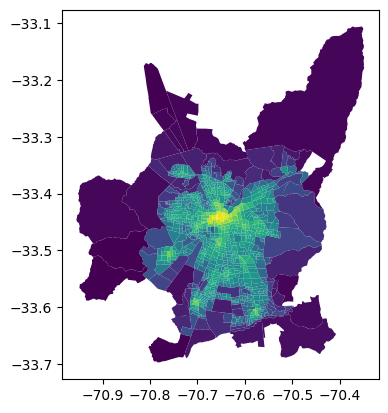

In [17]:
uv_hqsl.plot('hqsl')

## Upload data

In [18]:
aup.gdf_to_db_slow(uv_hqsl, 'santiago_unidadesvecinales_hqsl_4_5_kmh', 'projects_research', if_exists='append')

HQSL definition

In [14]:
def calculate_hqsl(hex_gdf, hex_low_res, scale_max_value, parameters_dict):

    # ------------------------------------------------------------
    # --- NORMALIZE SOURCES (_scaledcount columns)
    for social_function in parameters_dict.keys():
        aup.log(f"--- {social_function}")
        for theme in parameters_dict[social_function]:
            aup.log(f"------ {theme}")
            for source in parameters_dict[social_function][theme]:

                # Set col name of interest and find min and max values
                if 'count' in source:
                    count_colname = source
                else:
                    count_colname = f"{source}_count_15min"

                # Prepare for MinMax Scalar
                hex_gdf[count_colname] = hex_gdf[count_colname] + 0.001
                min_val = np.log(0.001)
                max_val = np.log(hex_low_res[count_colname]).max()
                print(f"for col {count_colname} original max_val: {hex_gdf[count_colname].max()} and min_val: {hex_gdf[count_colname].min()}")
                print(f"for col {count_colname} log max_val: {max_val} and min_val: {min_val}")

                # Calculate MinMax Scalar
                # scale_max_value = 10
                hex_gdf[f"{source}_scaledcount"] = hex_gdf[count_colname].apply(lambda x: scale_max_value * ((np.log(x) - min_val) /(max_val - min_val)))
                hex_gdf.loc[hex_gdf[f"{source}_scaledcount"]>scale_max_value, f"{source}_scaledcount"] = scale_max_value
                aup.log(f"------ Scaled {source} count.")
                ''' # Drop original count col
                hex_gdf.drop(columns=[count_colname],inplace=True)
                # Add
                scalar_count_column_list.append(f"{source}_scaledcount")'''

    aup.log(f"--- Scaled count columns added to hex_gdf.")
    
    # Keep columns of interest only
    # proxhexs_countprocess = proxhexs_countprocess[['hex_id','geometry']+scalar_count_column_list+['res','city']]

    # ------------------------------------------------------------
    # --- SUM NORMALIZED SOURCES BY THEME AND BY SOCIAL FUNCTION
    aup.log(f"--- Starting social function analysis.")
    sum_count_column_list = []

    for social_function in parameters_dict.keys():
        # Set social function sources list
        sf_sources_list = []
        
        for theme in parameters_dict[social_function]:
            # Set theme_sources_list and feed sf_sources_list
            theme_sources_list = []
            for source in parameters_dict[social_function][theme]:
                theme_sources_list.append(f"{source}_scaledcount")
                sf_sources_list.append(f"{source}_scaledcount")
                
            # Find sum of count anlysis for theme
            hex_gdf[f"{theme}_count"] = hex_gdf[theme_sources_list].sum(axis=1)
            aup.log(f"------ Summed {theme} count with a mean value of " + str(round(hex_gdf[f"{theme}_count"].mean(),4)))
            sum_count_column_list.append(f"{theme}_count")
            
        # Find sum of count anlysis for social function
        hex_gdf[f"{social_function}_count"] = hex_gdf[sf_sources_list].mean(axis=1)
        aup.log(f"--- Summed {social_function} count with a mean value of {round(hex_gdf[f'{social_function}_count'].mean(),4)}.")
        sum_count_column_list.append(f"{social_function}_count")

    # ------------------------------------------------------------
    # --- NORMALIZE SOCIAL FUNCTION COLUMNS AND CREATE HQLS
    # Get social function count columns
    social_fn_cols = []
    for k in parameters_dict.keys():
        social_fn_cols.append(k+'_count')

    # Normalize social function columns before creating HQSL
    for sc in social_fn_cols:
        # aup.log(f"--- Normalized social function {sc} from 0 to 30.")
        # hex_gdf[sc] = 30 * (hex_gdf[sc] - hex_gdf[sc].min()) / (hex_gdf[sc].max() - hex_gdf[sc].min())
        aup.log(f"--- Filling missing hexagons")
        hex_gdf.loc[hex_gdf.supermercado_time==0, sc] = hex_gdf.loc[hex_gdf.supermercado_time==0].apply(lambda x: neighbour_mean(x['hex_id'],
                                                                            'hex_id',
                                                                            hex_gdf,
                                                                            sc), axis=1)

    # Create HQSL
    hex_gdf['hqsl'] = hex_gdf[social_fn_cols[0]] + hex_gdf[social_fn_cols[1]] + hex_gdf[social_fn_cols[2]] + hex_gdf[social_fn_cols[3]] + hex_gdf[social_fn_cols[4]] + hex_gdf[social_fn_cols[5]]
    aup.log(f"--- Calculated HQSL with a mean value of {round(hex_gdf['hqsl'].mean(),4)}.")
    
    return hex_gdf

Filter hexs with no nodes before running HQSL

In [15]:
hex_diss = hex_low_res.loc[hex_low_res.supermercado_time>0].dissolve()
hex_clip = gpd.clip(hex_gdf, hex_diss)
hex_id_list = list(hex_clip.hex_id.unique())
hex_gdf = hex_gdf.loc[hex_gdf.hex_id.isin(hex_id_list)].copy()

# Show
print(hex_gdf.shape)
hex_gdf.head(1)

(9121, 123)


,hex_id,geometry,supermercado_time,supermercado_count_15min,clinica_priv_time,clinica_priv_count_15min,clinica_pub_time,clinica_pub_count_15min,hospital_priv_time,hospital_priv_count_15min,...,ciclovias_count_15min,eleam_time,eleam_count_15min,res,city,viv_count,oficinas_count,hotel_count,viv_social_count,ndvi_count
0,89b2c55085bffff,"POLYGON ((-70.79572 -33.40004, -70.79689 -33.4...",69.564997,0.0,53.321742,0.0,63.057446,0.0,173.61823,0.0,...,0.0,126.27579,0.0,9.0,Santiago,0.0,0.0,0.0,0.0,0.018576


<AxesSubplot: >

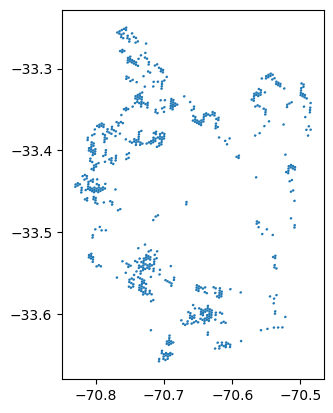

In [16]:
hex_gdf.loc[hex_gdf.supermercado_time==0].plot()

Calculate HQSL

In [17]:
hex_gdf = calculate_hqsl(hex_gdf, hex_low_res, 10, parameters_dict)

for col carniceria_count_15min original max_val: 10.001 and min_val: 0.001
for col carniceria_count_15min log max_val: 2.2079198664529676 and min_val: -6.907755278982137
for col hogar_count_15min original max_val: 27.001 and min_val: 0.001
for col hogar_count_15min log max_val: 3.0666840095262753 and min_val: -6.907755278982137
for col local_mini_market_count_15min original max_val: 94.21152631578948 and min_val: 0.001
for col local_mini_market_count_15min log max_val: 4.460121566456197 and min_val: -6.907755278982137
for col bakeries_count_15min original max_val: 50.353941176470585 and min_val: 0.001
for col bakeries_count_15min log max_val: 3.780748201004849 and min_val: -6.907755278982137
for col ferias_count_15min original max_val: 8.367666666666667 and min_val: 0.001
for col ferias_count_15min log max_val: 1.997425372002954 and min_val: -6.907755278982137
for col supermercado_count_15min original max_val: 14.629205128205127 and min_val: 0.001
for col supermercado_count_15min log m

/home/edgaregurrola/anaconda3/envs/odc/lib/python3.10/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/home/edgaregurrola/anaconda3/envs/odc/lib/python3.10/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/home/edgaregurrola/anaconda3/envs/odc/lib/python3.10/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resul

for col sitios_historicos_count_15min original max_val: 64.79345283018868 and min_val: 0.001
for col sitios_historicos_count_15min log max_val: 3.983847174624248 and min_val: -6.907755278982137
for col ndvi_count original max_val: 0.6434853804137999 and min_val: -0.023265052740557044
for col ndvi_count log max_val: -0.7539983600866187 and min_val: -6.907755278982137
for col cines_count_15min original max_val: 9.717216216216215 and min_val: 0.001
for col cines_count_15min log max_val: 2.193341077309822 and min_val: -6.907755278982137
for col librerias_count_15min original max_val: 23.60477358490566 and min_val: 0.001
for col librerias_count_15min log max_val: 3.0029734348105506 and min_val: -6.907755278982137
for col restaurantes_bar_cafe_count_15min original max_val: 184.001 and min_val: 0.001
for col restaurantes_bar_cafe_count_15min log max_val: 5.057956282434942 and min_val: -6.907755278982137
for col jardin_inf_pub_count_15min original max_val: 13.501 and min_val: 0.001
for col jar

/home/edgaregurrola/anaconda3/envs/odc/lib/python3.10/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/home/edgaregurrola/anaconda3/envs/odc/lib/python3.10/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/home/edgaregurrola/anaconda3/envs/odc/lib/python3.10/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resul

for col centro_edu_amb_count_15min original max_val: 1.001 and min_val: 0.001
for col centro_edu_amb_count_15min log max_val: 0.0 and min_val: -6.907755278982137
for col oficinas_count original max_val: 53.16564080937166 and min_val: 0.001
for col oficinas_count log max_val: 3.247319182424446 and min_val: -6.907755278982137
for col ciclovias_count_15min original max_val: 23.77877777777778 and min_val: 0.001
for col ciclovias_count_15min log max_val: 3.0842904052843805 and min_val: -6.907755278982137
for col paradas_tp_count_15min original max_val: 115.01236363636365 and min_val: 0.001
for col paradas_tp_count_15min log max_val: 4.665041210738592 and min_val: -6.907755278982137
for col paradas_tp_tren_count_15min original max_val: 2.001 and min_val: 0.001
for col paradas_tp_tren_count_15min log max_val: 0.5996211225491218 and min_val: -6.907755278982137
for col paradas_tp_metro_count_15min original max_val: 6.1642653061224495 and min_val: 0.001
for col paradas_tp_metro_count_15min log m

/home/edgaregurrola/anaconda3/envs/odc/lib/python3.10/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/home/edgaregurrola/anaconda3/envs/odc/lib/python3.10/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/home/edgaregurrola/anaconda3/envs/odc/lib/python3.10/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resul

### Results review

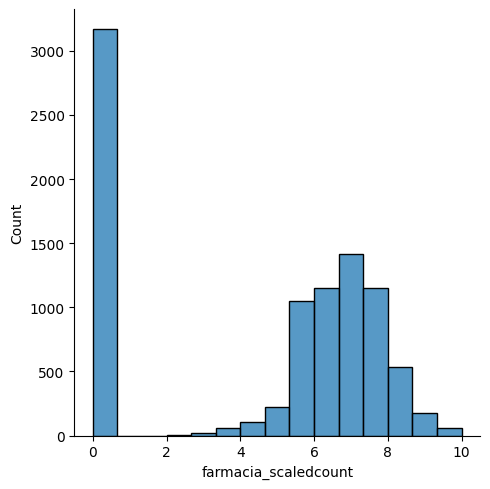

In [18]:
sns.displot(hex_gdf, x="farmacia_scaledcount")

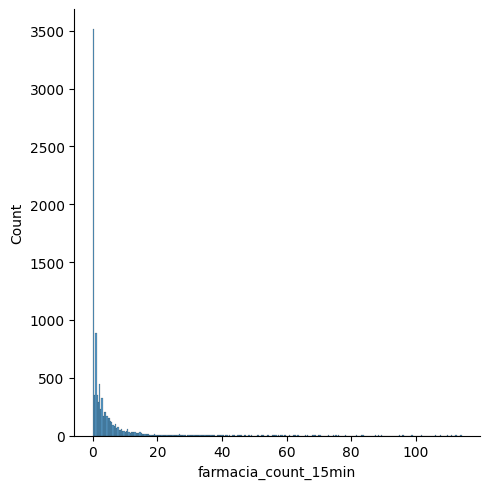

In [19]:
sns.displot(hex_gdf, x="farmacia_count_15min")

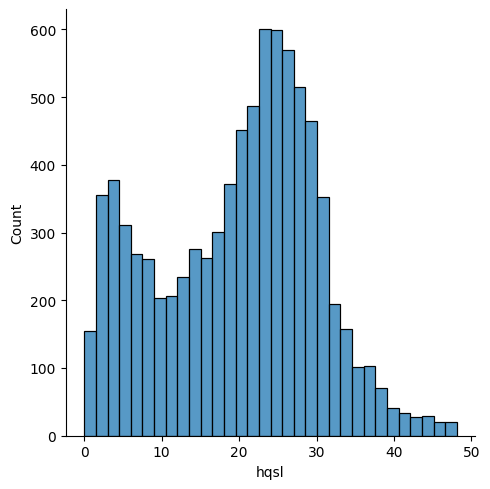

In [20]:
sns.displot(hex_gdf.loc[hex_gdf.supermercado_time>0],
            x=hex_gdf.loc[hex_gdf.supermercado_time>0,"hqsl"])

<AxesSubplot: >

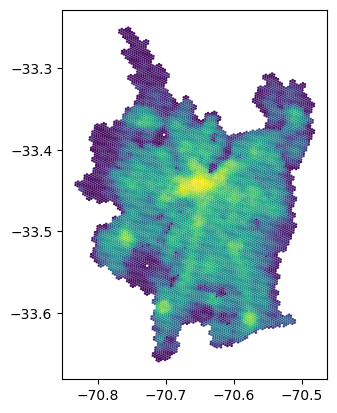

In [21]:
hex_gdf.plot('hqsl')

### Upload data

In [22]:
# Show
print(hex_gdf.shape)
print(hex_gdf.res.unique())
hex_gdf.head(1)

(9121, 201)
[9.]


,hex_id,geometry,supermercado_time,supermercado_count_15min,clinica_priv_time,clinica_priv_count_15min,clinica_pub_time,clinica_pub_count_15min,hospital_priv_time,hospital_priv_count_15min,...,culture_count,greenspace_count,entertainment_count,enjoying_count,education_count,learning_count,workplaces_count,sustainable_mobility_count,working_count,hqsl
0,89b2c55085bffff,"POLYGON ((-70.79572 -33.40004, -70.79689 -33.4...",69.564997,0.001,53.321742,0.001,63.057446,0.001,173.61823,0.001,...,0.0,4.8333,7.238974,1.509034,0.0,0.0,0.0,0.0,0.0,3.155563


In [23]:
if save:
    processed_table_name = 'santiago_hexproximity_hqsl_4_5_kmh_pub'
    aup.gdf_to_db_slow(hex_gdf, processed_table_name, 'projects_research', if_exists=if_exists)